# Comparison of MHMCMC and NUTS for Multivariate Gaussian and Ring

In [929]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

## 50 dimensional, highly correlated Gaussian

In [930]:
N = 100000
ndim= 50
try:
    with open("50dim0.7covar100000.pkl", "rb") as f:
        background_y = pickle.load(f)
except:
    mv_model = pm.Model()
    cov = np.identity(ndim)
    mu = np.zeros(ndim)
    np.place(cov, cov==0, 0.7)
    with mv_model:
        y = pm.MvNormal('y', mu=mu, cov=cov, shape=(1,ndim))
        #step = pm.Metropolis()
        trace = pm.sample(N)
    #pm.traceplot(trace)
    background_y = trace.get_values("y")

In [931]:
background_y = background_y.reshape(N, ndim)

In [932]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
background_y = pca.fit_transform(background_y)

In [945]:
sample_N = 500
cov = np.identity(ndim)
mu = np.zeros(ndim)
np.place(cov, cov==0, 0.7)

metr_mv_model = pm.Model()
nuts_mv_model = pm.Model()

with metr_mv_model:
    y = pm.MvNormal('y', mu=mu, cov=cov, shape=(1,ndim))
    step = pm.Metropolis(vars=[y])
    trace = pm.sample(sample_N, step=step, tune=1000)
metr_y = trace.get_values("y")
metr_y = metr_y.reshape(sample_N, ndim)
metr_y = pca.transform(metr_y)

with nuts_mv_model:
    y = pm.MvNormal('y', mu=mu, cov=cov, shape=(1,ndim))
    step = pm.NUTS(vars=[y])
    trace = pm.sample(sample_N, step=step, tune=1000)
nuts_y = trace.get_values("y")
nuts_y = nuts_y.reshape(sample_N, ndim)
nuts_y = pca.transform(nuts_y)

100%|██████████| 1500/1500 [00:00<00:00, 4285.62it/s]


ValueError: operands could not be broadcast together with shapes (500,2) (50,) 

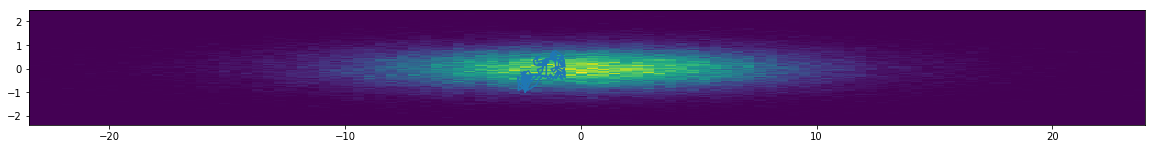

In [937]:
plt.figure(figsize=(20,20))
plt.gca().set_aspect('equal', adjustable='box')
_ = plt.hist2d(x=background_y[:,0], y=background_y[:,1], bins=100)
_ = plt.plot(metr_y.transpose()[0,:], metr_y.transpose()[1,:])

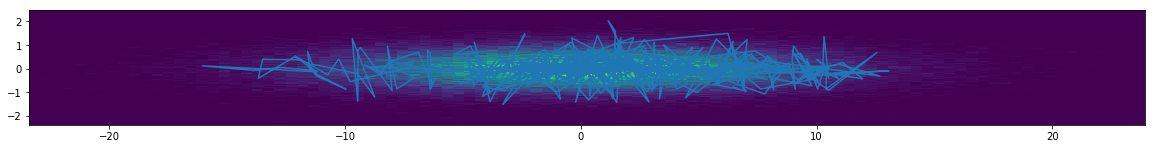

In [938]:
plt.figure(figsize=(20,20))
plt.gca().set_aspect('equal', adjustable='box')
_ = plt.hist2d(x=background_y[:,0], y=background_y[:,1], bins=100)
_ = plt.plot(nuts_y.transpose()[0,:], nuts_y.transpose()[1,:])

## Ring

In [955]:
ring_model = pm.Model()
N = 100000
ndim = 2

try:
    with open("ring2dim100000_v2.pkl", "rb") as f:
        background_y = pickle.load(f)
except:
    with ring_model:
        mu = pm.Normal('mu', mu=0, sd=1, shape=(ndim), testval=0.1)
        mu_circle = pm.Deterministic("mu_circle", 5*(mu/np.sqrt((mu**2).sum())))
        y = pm.MvNormal('y', mu=mu_circle, cov=np.identity(ndim)/10, shape=(1,ndim))
        step = pm.NUTS([mu, y])
        trace = pm.sample(N, step=step, tune=1000)
    background_y = trace.get_values("y")

In [956]:
background_y = background_y.reshape(N, ndim)

In [967]:
sample_N = 500

metr_ring_model = pm.Model()
nuts_ring_model = pm.Model()

with metr_ring_model:
    mu = pm.Normal('mu', mu=0, sd=1, shape=ndim, testval=0.1)
    mu_circle = pm.Deterministic("mu_circle", 5*(mu/np.sqrt((mu**2).sum())))
    y = pm.MvNormal('y', mu=mu_circle.flatten(), cov=np.identity(ndim)/10, shape=(ndim))
    step = pm.Metropolis(vars=[mu, y, mu_circle])
    trace = pm.sample(sample_N, step=step, tune=1000)
metr_ring_y = trace.get_values("y")
metr_ring_y = metr_ring_y.reshape(sample_N, ndim)

with nuts_ring_model:
    mu = pm.Normal('mu', mu=0, sd=1, shape=(ndim), testval=0.1)
    mu_circle = pm.Deterministic("mu_circle", 5*(mu/np.sqrt((mu**2).sum())))
    y = pm.MvNormal('y', mu=mu_circle, cov=np.identity(ndim)/10, shape=(1,ndim))
    step = pm.NUTS([mu, y])
    trace = pm.sample(sample_N, step=step, tune=1000)
nuts_ring_y = trace.get_values("y")
nuts_ring_y = nuts_ring_y.reshape(sample_N, ndim)

100%|█████████▉| 1497/1500 [00:39<00:00, 59.55it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.717660792556, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1500/1500 [00:39<00:00, 38.13it/s]


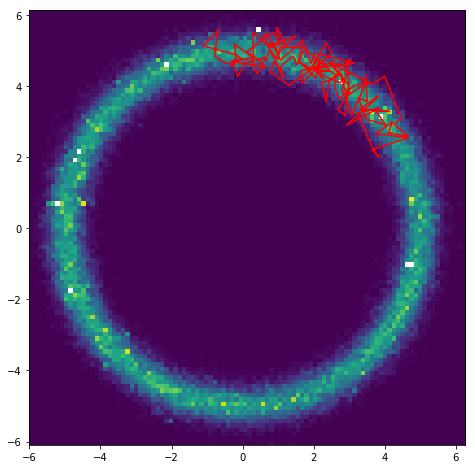

In [972]:
plt.figure(figsize=(8,8))
plt.gca().set_aspect('equal', adjustable='box')
_ = plt.hist2d(x=background_y.transpose()[0,:], y=background_y.transpose()[1,:],bins=100, cmax=100)
_ = plt.plot(metr_ring_y.transpose()[0,:], metr_ring_y.transpose()[1,:], "r")

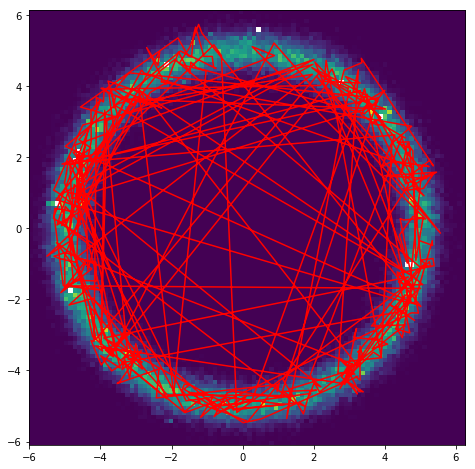

In [971]:
plt.figure(figsize=(8,8))
plt.gca().set_aspect('equal', adjustable='box')
_ = plt.hist2d(x=background_y.transpose()[0,:], y=background_y.transpose()[1,:],bins=100, cmax=100)
_ = plt.plot(nuts_ring_y.transpose()[0,:], nuts_ring_y.transpose()[1,:], "r")